```
Task associated with discrete optimization:

Weights for all of the inventory was deleted from the database, without knowing each present's weights he didn't know how he would pack his many gift bags. How to fill multiple bags with sets of uncertain gifts ?


Problem Description
-------------------


Santa has 1000 bags to fill with 9 types of gifts. Due to regulations at the North Pole workshop, no bag can contain more than 50 pounds of gifts. If a bag is overweight, it is confiscated by regulators from the North Pole Department of Labor without warning!

Each present has a fixed weight, but the individual weights are unknown. The weights for each present type are not identical because the elves make them in many types and sizes.

Although the weights were deleted from the database, the elves still have the blueprints for each toy. After some complex volume integrals, the elves managed to give Santa a probability distribution for the weight of each type of toy. To simulate a single gift's weight in pounds, they came up with the following numpy distribution parameters:

horse = max(0, np.random.normal(5,2,1)[0])

ball = max(0, 1 + np.random.normal(1,0.3,1)[0])

bike = max(0, np.random.normal(20,10,1)[0])

train = max(0, np.random.normal(10,5,1)[0])

coal = 47 * np.random.beta(0.5,0.5,1)[0]

book = np.random.chisquare(2,1)[0]

doll = np.random.gamma(5,1,1)[0]

block = np.random.triangular(5,10,20,1)[0]

gloves = 3.0 + np.random.rand(1)[0] if np.random.rand(1) < 0.3 else np.random.rand(1)[0]

```

```
Evaluation:
-----------


Submissions are evaluated on the total amount of weight you fit into Santa's 1000 bags. The rules that govern gift packing are as follows:

- Overfilling a bag above the 50lb limit will cause the entire bag to count for nothing, without warning!
- No gift may be used more than once.
- Every bag must have 3 or more gifts.


Note: You do not need to include all GiftIds or all bags when submitting.
```

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [14]:
gifts = pd.read_csv('../data/gifts.csv'); gifts.head()

,GiftId
0,horse_0
1,horse_1
2,horse_2
3,horse_3
4,horse_4


In [3]:
# just to verify whether each gift is distinct or not
assert gifts.GiftId.nunique() == len(gifts)

` Probability distribution for weights for horse `

In [15]:
def horse_weight_distribution(sample_size):
    horse_draws = np.random.normal(loc=5.0, scale=2.0, size=sample_size)
    return np.array([max(0, val) for val in horse_draws])

def ball_weight_distribution(sample_size):
    ball_draws = 1 + np.random.normal(1, 0.3, sample_size)
    return np.array([max(0, val) for val in ball_draws])

def bike_weight_distribution(sample_size):
    bike_draws =  np.random.normal(20, 10, sample_size)
    return np.array([max(0, val) for val in bike_draws])

def train_weight_distribution(sample_size):
    train_draws = np.random.normal(10, 5, sample_size)
    return np.array([max(0, val) for val in train_draws])

def coal_weight_distribution(sample_size):
    return 47 * np.random.beta(0.5, 0.5, sample_size)

def book_weight_distribution(sample_size):
    return np.random.chisquare(2,sample_size)

def doll_weight_distribution(sample_size):
    return np.random.gamma(5,1, sample_size)

def block_weight_distribution(sample_size):
    return np.random.triangular(5,10,20,sample_size)

def gloves_weight_distribution(sample_size):
    return np.array([3.0 + np.random.rand(1)[0] if np.random.rand(1) < 0.3 else np.random.rand(1)[0] for i in range(sample_size)])

def draw_distributions(gift_type, sample_size=1000):
    if gift_type == 'horse':
        return horse_weight_distribution(sample_size)
    elif gift_type == 'ball':
        return ball_weight_distribution(sample_size)
    elif gift_type == 'bike':
        return bike_weight_distribution(sample_size)
    elif gift_type == 'train':
        return train_weight_distribution(sample_size)
    elif gift_type == 'coal':
        return coal_weight_distribution(sample_size)
    elif gift_type == 'book':
        return book_weight_distribution(sample_size)
    elif gift_type == 'doll':
        return doll_weight_distribution(sample_size)
    elif gift_type == 'blocks':
        return block_weight_distribution(sample_size)
    else:
        return gloves_weight_distribution(sample_size)

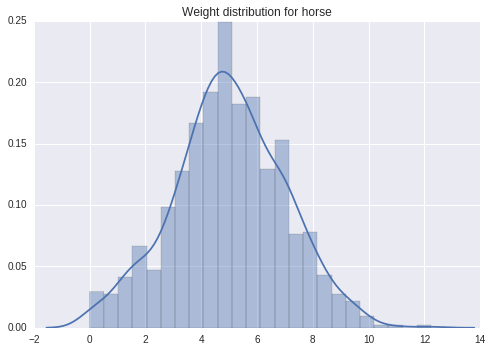

In [28]:
horse_weight_samples = draw_distributions('horse')
sns.distplot(horse_weight_samples)
plt.title('Weight distribution for horse');

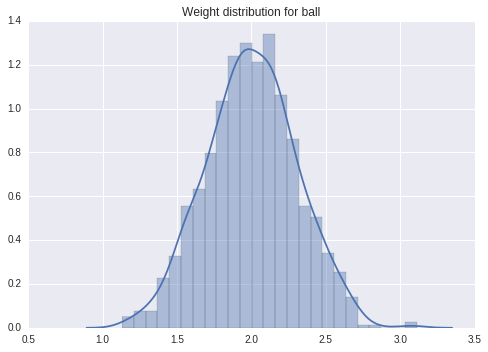

In [29]:
ball_weight_samples = draw_distributions('ball')
sns.distplot(ball_weight_samples)
plt.title('Weight distribution for ball');

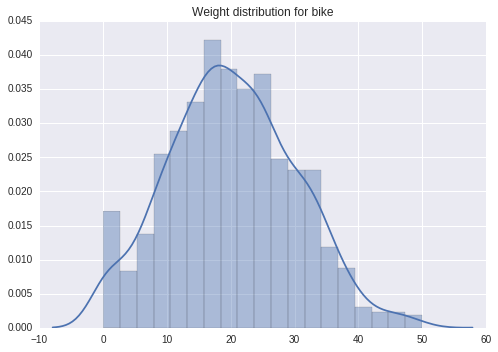

In [30]:
bike_weight_samples = draw_distributions('bike')
sns.distplot(bike_weight_samples)
plt.title('Weight distribution for bike');

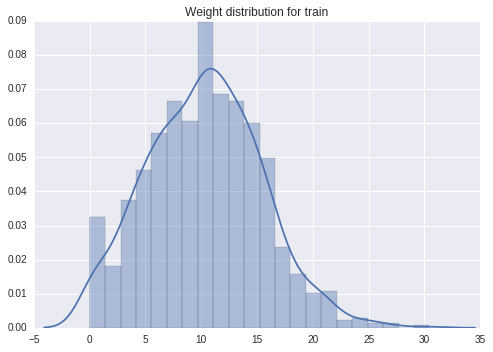

In [31]:
train_weight_samples = draw_distributions('train')
sns.distplot(train_weight_samples)
plt.title('Weight distribution for train');

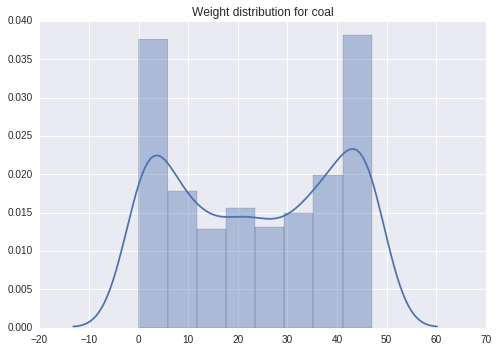

In [32]:
coal_weight_samples = draw_distributions('coal')
sns.distplot(coal_weight_samples)
plt.title('Weight distribution for coal');

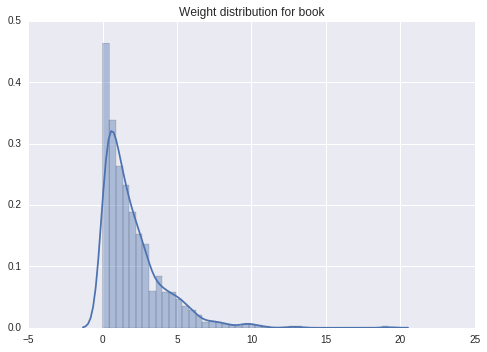

In [33]:
book_weight_samples = draw_distributions('book')
sns.distplot(book_weight_samples)
plt.title('Weight distribution for book');

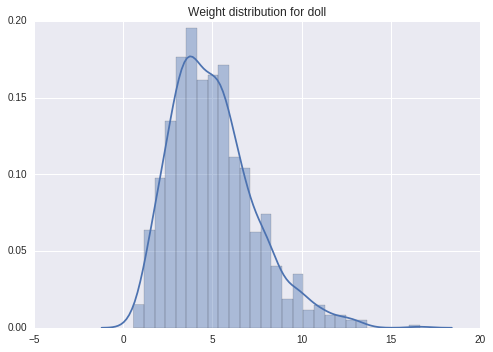

In [34]:
doll_weight_samples = draw_distributions('doll')
sns.distplot(doll_weight_samples)
plt.title('Weight distribution for doll');

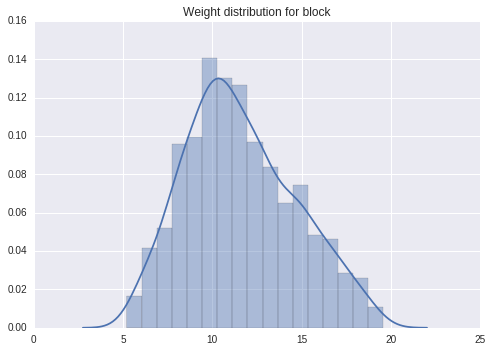

In [35]:
block_weight_samples = draw_distributions('block')
sns.distplot(block_weight_samples)
plt.title('Weight distribution for block');

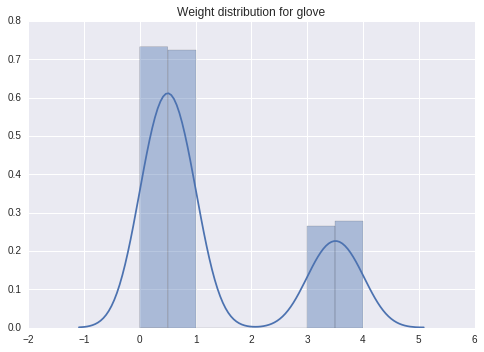

In [36]:
glove_weight_samples = draw_distributions('glove')
sns.distplot(glove_weight_samples)
plt.title('Weight distribution for glove');

In [16]:
# Gift composition
gift_types = pd.Series(list(zip(*gifts.GiftId.str.split('_').values))[0])
num_gift_types = gift_types.value_counts().to_dict()

In [17]:
print('Number of gifts available: \n')
print(num_gift_types)

Number of gifts available: 

{'gloves': 200, 'blocks': 1000, 'horse': 1000, 'bike': 500, 'book': 1200, 'train': 1000, 'ball': 1100, 'coal': 166, 'doll': 1000}


** Coal has the least quantity and gloves have the highest quantity **

** How much weight can we possibly carry in 1000 bags with respecting constraint that no bag can contain more than 50 pounds ? **

In [19]:
# standard deviation for all of the gift types
gift_types = list(num_gift_types.keys())
gift_types_std = np.array([(gf, draw_distributions(gf, sample_size=10000).mean(), draw_distributions(gf, sample_size=10000).std()) for gf in gift_types])

In [20]:
gift_types_std

array([['gloves', '1.3766108451', '1.40399340917'],
       ['blocks', '11.7191041063', '3.10063143142'],
       ['horse', '5.01999877228', '1.97577943025'],
       ['bike', '20.0420998859', '9.90515933508'],
       ['book', '2.0279211218', '2.00984080968'],
       ['train', '10.0077036142', '4.86928336637'],
       ['ball', '1.99893039716', '0.300137992174'],
       ['coal', '23.4757106497', '16.6542922335'],
       ['doll', '4.96909468425', '2.23143900178']], 
      dtype='<U14')

In [32]:
with open('../data/custom_packaging.csv', 'w') as outfile:
        outfile.write("Gifts\n")
        for i in range(1000):
            outfile.write(packaging_strings[i] + '\n')
        outfile.close()